# Isolated micro-bubble

Micro-bubble behaviour in Stride is modelled using the Marmottant model [1], which has been implemented using [Devito](https://www.devitoproject.org/).

$$
    \rho_l \left( R\ddot{R} + \frac{3}{2} \dot{R}^2 \right) = \left[ P_0 + \frac{2 \sigma(R_0)}{R_0} \right]
\left( \frac{R}{R_0} \right)^{-3\kappa} \left( 1 - \frac{3\kappa}{v_p}\dot{R} \right) - P_0 - \frac{2\sigma(R)}{R} - \frac{4\mu\dot{R}}{R} - \frac{4\kappa_s\dot{R}}{R^2} - p
$$

where $\sigma(R)$ is the effective surface tension, given by,

$$
    \sigma(R) = \left\{\begin{array}{lr} 0 \text{ if } R\leq R_{buckling}\\ \chi \left( \frac{R^2}{R_{buckling}^2} - 1 \right) \text{ if } R_{buckling}\leq R\leq R_{break}\\ \sigma_l \text{ if } R\geq R_{break} \end{array}\right.
$$

where $R(t)$ is the instantaneous bubble radius, $v_p(\mathbf{x})$, $\rho(\mathbf{x})$, $\sigma_l(\mathbf{x})$, and $\mu(\mathbf{x})$ are respectively the longitudinal speed of sound, mass density, surface tension, and viscosity of the surrounding liquid; $P_0$ is the ambient pressure, $\kappa$ is the polytropic gas exponent, $\kappa_s$ is the surface dilatational viscosity from the monolayer, $\chi$ is the elastic compression modulus of the monolayer, $R_{buckle}$ is the buckling radius of the bubble, $R_{break}$ is the breaking radius of the bubble, and $p(t, \mathbf{x})$ is the acoustic pressure.

The Marmottant ordinary diffential equation (ODE) is integrated in time using a 4th-order Runge-Kutta time stepping algorithm.

To start our bubble simulation, let's import necessary libraries,

In [1]:
from stride import *
%matplotlib widget

import numpy as np

and create our grid. In this case, because our equation is only dependent on time, we will only need to generate a time discretisation.

In [2]:
time = Time(start=0., step=1e-9, num=10000)

As usual, we also instantiate our `problem` container.

In [3]:
problem = Problem(name='isolated_bubble', time=time)

Now, let's define the properties that determine our bubble and its surrounding liquid.

In [4]:
vp = 1540           # [m/s]     the speed of sound in the surrounding liquid
rho = 997           # [kg/m^3]  the density of the surrounding liquid
sigma = 0.073       # [N/m]     the surface tension of the surrounding liquid
mu = 0.002          # [Pa s]    the viscosity of the surrounding liquid
p_0 = 101325        # [Pa]      the ambient pressure
kappa = 1.07        # [-]       the polytropic gas exponent
kappa_s = 5E-9      # [N]       the surface dilatational viscosity from the monolayer
chi = 0.4           # [N/m]     the elastic compression modulus of the monolayer
r_buckle = 2.08e-6  # [m]       the buckling radius of the bubble
r_break = 2.28e-6   # [m]       the breaking radius of the bubble

We will also need to define the initial condition of our ODE, that is the initial radius of the bubble that we are going to simulate. We do this by instantiating a `SparseField` object.

In [5]:
r_0 = SparseField(name='r_0', num=1, grid=problem.grid)
r_0.data[0] = 2.20e-06

Notice that we have set the parameter `num=1`. If we wanted to run multiple bubbles at the same time, it would be as easy as setting this parameter to a larger number.

Then, we need to define the external pressure that is going to excite the bubble.

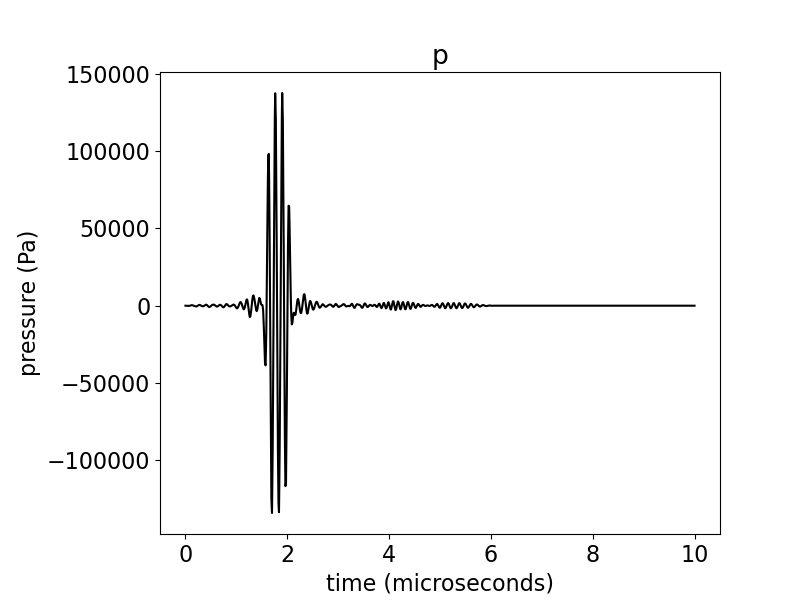

In [6]:
from utils import test_signal
import matplotlib.pyplot as plt

p = Traces(name='p', transducer_ids=[0], grid=problem.grid)
p.data[0, :] = test_signal(time.num)

p.plot_one(0, plot=False)
plt.xlabel('time (microseconds)')
plt.ylabel('pressure (Pa)')
plt.subplots_adjust(left=0.2)
plt.show()

Finally, let's instatiate our ODE object,

In [7]:
# Create ODE
ode = MarmottantDevito(time=time)

Default Devito configuration:
	 * autotuning=['aggressive', 'runtime']
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp
(1,) (2,) (0,) None None


and run it passing in the bubble parameters.

In [8]:
# Run
r = await ode(r_0,
              vp=vp, rho=rho, sigma=sigma, mu=mu,
              p_0=p_0, p=p, kappa=kappa, kappa_s=kappa_s,
              chi=chi, r_buckle=r_buckle, r_break=r_break)

Preparing to run state for shot
Operator `marmottant_state` instance configuration:
	 * name=marmottant_state
	 * subs={h_x: 1.0, dt: 1e-09}
	 * opt=advanced
Operator `marmottant_state` generated in 1.31 s
  * lowering.Clusters: 0.72 s (55.1 %)
     * specializing.Clusters: 0.54 s (41.3 %)
  * lowering.IET: 0.30 s (23.0 %)
Flops reduction after symbolic optimization: [630 --> 256]
Operator `marmottant_state` fetched `/tmp/devito-jitcache-uid1000/e9e3f685842ec174ed3869ab97a7d760599c89d0.c` in 0.12 s from jit-cache
Running state equation for shot
AutoTuner: could not perform any runs
Operator `marmottant_state` ran in 0.06 s
Global performance: [OI=2.05, 0.05 GFlops/s, 0.01 GPts/s]
Global performance <w/o setup>: [0.06 s, 0.01 GPts/s]
Local performance:
  * section0 ran in 0.03 s [OI=0.63, 0.01 GFlops/s]
  * section1 ran in 0.04 s [OI=2.05, 0.08 GFlops/s, 0.01 GPts/s]
Performance[mode=advanced] arguments: {'nthreads': 6, 'pthreads': 0}
Completing state equation run for shot
Completed sta

We can visualise the resulting bubble radius behaviour by plotting the output `r`.

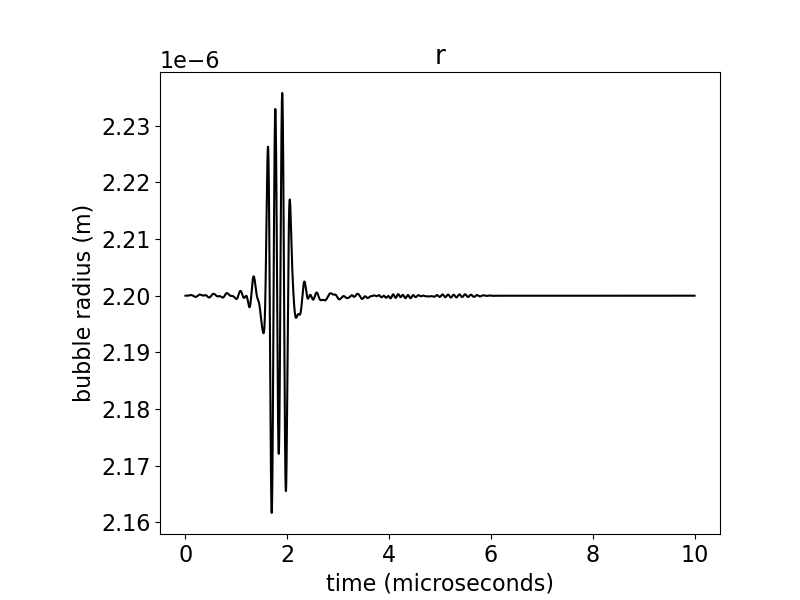

In [9]:
r.plot_one(0, plot=False)
plt.xlabel('time (microseconds)')
plt.ylabel('bubble radius (m)')
plt.subplots_adjust(left=0.2)
plt.show()

[1] Philippe Marmottant, Sander van der Meer, Marcia Emmer, and Michel Versluis, "A model for large amplitude oscillations of coated bubbles accounting for buckling and rupture", The Journal of the Acoustical Society of America 118, 3499 (2005) https://doi.org/10.1121/1.2109427